### Open File

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('./data/df_features.gz')

I delete the rows without a distance to city center (because in the origin hotel don't have latitude and longitude)

In [3]:
df = df.dropna(subset=['Dist_Center'])
# df = df.dropna(subset=['Reservation_ADR'])

### Create Predicted Category for final models (2 categories)

In [4]:
diff_hotels = df[['Hotel_Address','Diff']].groupby('Hotel_Address').describe()
diff_hotels = diff_hotels.Diff.reset_index()

In [5]:
df = pd.merge(df, diff_hotels, on='Hotel_Address')

In [6]:
category = np.array(['Bad' if i < -2 else 'Good' for i in df.Diff])
df.loc[:, 'Category'] = category
df.Category.value_counts() / len(df)

Good    0.890544
Bad     0.109456
Name: Category, dtype: float64

In [7]:
df.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score',
       'days_since_review', 'lat', 'lng', 'Diff', 'Diff_Percentage',
       'Review_Month', 'Review_Year', 'Country', 'City', 'Pet', 'Purpose',
       'Whom', 'Room', 'Length', 'Device', 'Room_Recode', 'Nationality_Recode',
       'Length_Recode', 'Close_Landmarks', 'Dist_Center', 'Dist_Airport',
       'Dist_Train', 'Price', 'Stars', 'Length_N', 'Reservation_ADR',
       'food_Neg', 'staff_Neg', 'location_Neg', 'value_Neg', 'comfort_Neg',
       'room_Neg', 'facilities_Neg', 'cleanliness_Neg', 'food_Pos',
       'staff_Pos', 'location_Pos', 'value_Pos', 'comfort_Pos', 'room_Pos',
       'facilities_Pos', 'cleanliness_Pos', 'food_Neg_Hotel',
       'staff_Neg_Hotel', 'loca

### Balance Nationalities and / or Categories

In [8]:
def balance_df(Balance_Nationality, Balance_Category):
    df_balance_country = df.copy()
    if Balance_Nationality:
        df_balance_country = None
        for i in list(df.Nationality_Recode.value_counts().index):
            nationality = df[df.Nationality_Recode == i]
            n = 20000
            if len(nationality) < 20000:
                n = len(nationality)
            nationality = nationality.sample(n, random_state=1)
            df_balance_country = pd.concat([df_balance_country, nationality])
    
    df_balance_class = df_balance_country.copy()
    if Balance_Category:
        df_balance_class = None
        minclass = np.min(df_balance_country.Category.value_counts())
        classes = list(df_balance_country.Category.value_counts().index)
        for i in classes:
            selected_class = df_balance_country[df_balance_country.Category == i].sample(minclass, random_state=1)
            df_balance_class = pd.concat([df_balance_class, selected_class])
    
    return(df_balance_class)

In [9]:
df_balanced = balance_df(Balance_Nationality=True, Balance_Category=True)

### Prepare Data to run Models

In [10]:
df_model = df_balanced.sample(n=20000, random_state=1)

In [14]:
x_categorical = ['Review_Month','City','Pet','Purpose','Whom','Room_Recode','Nationality_Recode','Length_Recode','Stars']
x_numerical = ['Average_Score', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Close_Landmarks', 'Dist_Center', 
               'Dist_Train', 'Dist_Airport','food_Neg_Hotel','staff_Neg_Hotel', 'location_Neg_Hotel', 'value_Neg_Hotel',
               'comfort_Neg_Hotel', 'room_Neg_Hotel', 'facilities_Neg_Hotel','cleanliness_Neg_Hotel', 
               'food_Pos_Hotel', 'staff_Pos_Hotel','location_Pos_Hotel', 'value_Pos_Hotel', 'comfort_Pos_Hotel',
               'room_Pos_Hotel', 'facilities_Pos_Hotel', 'cleanliness_Pos_Hotel','count', 'mean', 'std', 'min', '25%', 
               '50%', '75%', 'max']
x_col = x_categorical + x_numerical
y_col = 'Category'

In [15]:
X_numerical = df_model[x_numerical]
X_numerical_std = X_numerical.apply(lambda x: ((x-np.mean(x)) / np.std(x)))

In [16]:
X_categorical = pd.get_dummies(df_model[x_categorical], prefix_sep='_', drop_first=True)
X_categorical = X_categorical.fillna('Not Available')

In [17]:
X = pd.concat([X_numerical_std, X_categorical], axis=1, sort=False)
y = df_model[y_col]

Split into Train and Test

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=100)

In [19]:
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((10000, 67), (10000,), (10000, 67), (10000,))

## MODELS

### Evaluate Model

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB

from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, f1_score, precision_score, recall_score

In [21]:
def evaluate(model):
    clf = model
    clf.fit(X_train, y_train)
    train = clf.predict(X_train)
    pred = clf.predict(X_test)
    print('Test :', f'{accuracy_score(pred, y_test):.4f}', '|', f'{cohen_kappa_score(pred, y_test):.4f}')
    print('Train:', f'{accuracy_score(train, y_train):.4f}', '|', f'{cohen_kappa_score(train, y_train):.4f}')
    return(pred)

### KNN

In [22]:
pred_knn = evaluate(KNeighborsClassifier(n_neighbors=5))

Test : 0.5482 | 0.0963
Train: 0.7046 | 0.4091


### Gradient Boosted Trees

In [23]:
pred_gbt = evaluate(GradientBoostingClassifier(learning_rate=0.04, max_depth=3, random_state=1))

Test : 0.6140 | 0.2283
Train: 0.6382 | 0.2765


### Random Forest

In [24]:
pred_rf = evaluate(RandomForestClassifier(n_estimators = 75, max_depth = 5, random_state=1))

Test : 0.6090 | 0.2186
Train: 0.6267 | 0.2539


### XGBoosting

In [25]:
pred_xgb = evaluate(xgb.XGBClassifier(objective="binary:logistic", n_estimators = 7, max_depth=4, random_state=1))

Test : 0.6062 | 0.2129
Train: 0.6387 | 0.2777


### Logistic Regresion

In [26]:
pred_log = evaluate(LogisticRegression(solver='lbfgs', max_iter=500, random_state=1))

Test : 0.6144 | 0.2289
Train: 0.6236 | 0.2470


### Decision Trees

In [27]:
pred_tree = evaluate(DecisionTreeClassifier(max_depth=4, random_state=1))

Test : 0.6096 | 0.2194
Train: 0.6106 | 0.2213


### SVM

In [28]:
pred_svm = evaluate(SVC(C=0.5, random_state=1))

Test : 0.6102 | 0.2208
Train: 0.6415 | 0.2832


### Naive Bayes

In [29]:
pred_nb = evaluate(BernoulliNB())

Test : 0.5975 | 0.1951
Train: 0.5904 | 0.1807


### Models Summary

In [30]:
df_models_test = pd.DataFrame(list(zip(y_test, pred_log, pred_knn, pred_xgb, pred_gbt, pred_rf, 
                                       pred_svm, pred_tree, pred_nb)), 
                         columns=['TEST','logistic','knn','xgb','gbt','rf','svm', 'tree', 'nb']) 
df_models_test.head()

,TEST,logistic,knn,xgb,gbt,rf,svm,tree,nb
0,Good,Good,Bad,Good,Good,Bad,Good,Good,Good
1,Good,Good,Good,Good,Good,Good,Good,Good,Good
2,Good,Bad,Bad,Bad,Bad,Bad,Bad,Bad,Bad
3,Bad,Bad,Bad,Bad,Bad,Bad,Bad,Bad,Bad
4,Bad,Bad,Good,Bad,Bad,Good,Good,Bad,Good


## STACKING

Predictions using Random Forest adding the predicions of other models to the original dataset.
I had to split the test set in 2 to create the new train/test set, otherwise i fall into overfitting because my original training set is biased vs the test set

First I append the predictions of the model to the dataset

In [31]:
X_2 = X_test.copy()
y_2 = y_test.copy()

In [32]:
X_2['logistic'] = pred_log
X_2['gbt'] = pred_gbt
X_2['knn'] = pred_knn
X_2['svm'] = pred_svm
X_2['tree'] = pred_tree
X_2['xgb'] = pred_xgb
X_2['nb'] = pred_nb
X_2['rf'] = pred_rf

In [33]:
X_2.iloc[:,-8:].head(2)

,logistic,gbt,knn,svm,tree,xgb,nb,rf
483844,Good,Good,Bad,Good,Good,Good,Good,Bad
49888,Good,Good,Good,Good,Good,Good,Good,Good


In [34]:
X_2.iloc[:,-8:] = X_2.iloc[:,-8:].apply(lambda x: [1 if i=='Good' else 0 for i in x])

In [35]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=100)

### Stacked Model

In [36]:
models = [('Random Forest', RandomForestClassifier(n_estimators = 90, max_depth = 4, random_state=1)), 
          ('XGB', xgb.XGBClassifier(objective="binary:logistic", n_estimators = 2, max_depth=4, random_state=1)),
          ('GBT', GradientBoostingClassifier(learning_rate=0.005, max_depth=3, random_state=1)),
          ('Logistic', LogisticRegression(solver='lbfgs', max_iter=1000, random_state=1)),
          ('SVM', SVC(C=0.5, random_state=1))
         ]

for i in models:
    clf = i[1]
    clf.fit(X_train_2, y_train_2)
    train_stck_2 = clf.predict(X_train_2)
    pred_stck_2 = clf.predict(X_test_2)
    print(i[0])
    print('Test :',f'{accuracy_score(pred_stck_2, y_test_2):.4f}', '|',f'{cohen_kappa_score(pred_stck_2, y_test_2):.4f}')
    print('Train:',f'{accuracy_score(train_stck_2, y_train_2):.4f}', '|',f'{cohen_kappa_score(train_stck_2, y_train_2):.4f}')
    print('----------------------')

Random Forest
Test : 0.6065 | 0.2146
Train: 0.6266 | 0.2533
----------------------
XGB
Test : 0.6115 | 0.2237
Train: 0.6272 | 0.2545
----------------------
GBT
Test : 0.6090 | 0.2187
Train: 0.6224 | 0.2448
----------------------
Logistic
Test : 0.6265 | 0.2528
Train: 0.6219 | 0.2438
----------------------
SVM
Test : 0.6110 | 0.2231
Train: 0.6268 | 0.2535
----------------------


#### Backward Elimination

In [37]:
import random
from random import sample

In [38]:
def check_model(variable, X_train, X_test, y_train, y_test):
    clf = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=1)    
    clf.fit(X_train, y_train)
    prediccion = clf.predict(X_test)
    acc_score = accuracy_score(prediccion, y_test)
    return(variable, acc_score)

In [45]:
def try_seed(seed, verbose=False):
    score = check_model('', X_train_2, X_test_2, y_train_2, y_test_2)[1]
    varout = []
    varin = list(X_test_2.columns)

    for n in range(len(varin)):
        max_score = score
        max_feature = []
        random.seed(seed)
        
        for i in sample(varin, len(varin)):
            var_test = varin.copy()
            var_test.remove(i)
            X_train_vartest = X_train_2[var_test]
            X_test_vartest = X_test_2[var_test]
            check = check_model(i, X_train_vartest, X_test_vartest, y_train_2, y_test_2)
            if check[1] > max_score:
                max_feature = check[0]
                max_score = check[1] 
                varin.remove(max_feature)   
                varout.append(max_feature)
                if verbose:
                    print('{0:0=2d}'.format(n), 'Original Score:', f'{score:.4f}', '| New score:', f'{max_score:.4f}', 
                          '| Variable to remove:', max_feature)
                break

        if max_score > score:
            score = max_score
        else:
            print('Seed:',seed, '<-', score)
            return(varin, score)
            break

In [46]:
max_score = 0
var_selec = []
for seed in range(20):
    varin, score = try_seed(seed)
    if score > max_score:
        max_score = score
        var_selec = varin

Seed: 0 <- 0.635
Seed: 1 <- 0.6395
Seed: 2 <- 0.637
Seed: 3 <- 0.6445
Seed: 4 <- 0.634
Seed: 5 <- 0.6355
Seed: 6 <- 0.6425
Seed: 7 <- 0.6405
Seed: 8 <- 0.644
Seed: 9 <- 0.6375
Seed: 10 <- 0.6385
Seed: 11 <- 0.6405
Seed: 12 <- 0.645
Seed: 13 <- 0.6405
Seed: 14 <- 0.64
Seed: 15 <- 0.6375
Seed: 16 <- 0.6415
Seed: 17 <- 0.6385
Seed: 18 <- 0.6345
Seed: 19 <- 0.6345


In [40]:
X_train_varin = X_train_2[varin]
X_test_varin = X_test_2[varin]
clf = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=1)    
clf.fit(X_train_varin, y_train_2)
prediction = clf.predict(X_test_varin)
probability = clf.predict_proba(X_test_varin)

(array([  4.,  27.,  38.,  64.,  91., 119., 129., 168., 167., 198., 164.,
        183., 164., 134., 132.,  88.,  58.,  42.,  18.,  12.]),
 array([0.11944471, 0.15764404, 0.19584336, 0.23404269, 0.27224202,
        0.31044135, 0.34864068, 0.38684   , 0.42503933, 0.46323866,
        0.50143799, 0.53963732, 0.57783665, 0.61603597, 0.6542353 ,
        0.69243463, 0.73063396, 0.76883329, 0.80703261, 0.84523194,
        0.88343127]),
 <a list of 20 Patch objects>)

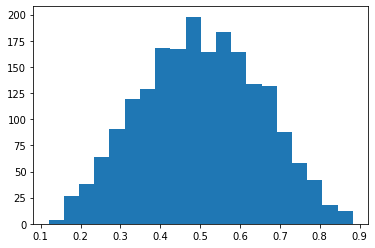

In [41]:
plt.hist(probability[:,1], bins=20)

In [42]:
pd.crosstab(prediction, y_test_2)

Category,Bad,Good
row_0,,
Bad,619,379
Good,347,655


### Ensemble

In [43]:
modelos = [('Logistic', LogisticRegression(solver='lbfgs', max_iter=1500, random_state=1)), 
           ('Random Forest', RandomForestClassifier(n_estimators = 70, max_depth = 5, random_state=1)),
           ('XGB', xgb.XGBClassifier(objective="binary:logistic", n_estimators = 4, max_depth=5, random_state=1))]

pred = pd.DataFrame(columns=['Logistic','Random Forest','XGB'])
prob = pd.DataFrame(columns=['Logistic','Random Forest','XGB'])

for i in modelos:
    clf = i[1]
    clf.fit(X_train_2, y_train_2)
    train_stck_2 = clf.predict(X_train_2)
    pred_stck_2 = clf.predict(X_test_2)
    prob_stck_2 = clf.predict_proba(X_test_2)

    pred[i[0]] = pred_stck_2
    prob[i[0]] = prob_stck_2[:,0]

print('Done!')

Done!


In [44]:
prob_final = prob.apply(lambda x: np.mean(x), axis=1)
prob_final = ['Good' if i < 0.5 else 'Bad' for i in prob_final]
print('Probability :',  
      f'{accuracy_score(prob_final, y_test_2):.4f}', '|', 
      f'{cohen_kappa_score(prob_final, y_test_2):.4f}')

Probability : 0.6200 | 0.2406
